In [45]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from keras import regularizers, layers, optimizers, initializers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(f'Current GPU allocator: {os.getenv("TF_GPU_ALLOCATOR")}')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(f'Setting memory growth for {gpu}')
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    

Current GPU allocator: cuda_malloc_async
Setting memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [46]:
study_name = '420_stdminmaxpower_allfeatures_3'

In [47]:

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [48]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [5]:
# # FOR TESTING IMAGE AUGEMENTATION
# train_df = train_df.sample(1000)
# test_df = test_df.sample(1000)

In [49]:
feat = test_df.copy()
FEATURE_COLS = feat.columns[1:].tolist()

In [50]:
sd_columns = [col for col in train_df.columns if col.endswith('_sd')]
train_df.drop(columns=sd_columns, inplace=True)

In [51]:
train_images_path = './data/train_images/'
test_images_path = './data/test_images/'    

train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))

In [52]:
for column in mean_columns:
    lower_quantile = train_df[column].quantile(0.005)
    upper_quantile = train_df[column].quantile(0.985)  
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]

In [53]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, trait in enumerate(mean_columns):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold

/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [54]:
scaler_feat = RobustScaler()

train_original = train_df.copy()
train_plot = train_df.copy()
sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler_feat.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler_feat.transform(valid_df[FEATURE_COLS].values)

# Num Train: 39335 | Num Valid: 9833


/tmp/ipykernel_1710502/1274913921.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler_feat.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_1710502/1274913921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler_feat.transform(valid_df[FEATURE_COLS].values)


In [12]:
import glob



directory_path = './NN_search'
pattern = f"{directory_path}/{study_name}*.h5"

files = glob.glob(pattern)

max_r2_score = float('-inf')
best_model = None

# Käy läpi jokainen tiedosto ja etsi suurin r2_score_inv
for file in files:
    value = float(file.split('best_val')[1].split('_')[1])
    if value > max_r2_score:
        max_r2_score = value
        best_model = file


# Tulosta suurin löydetty r2_score_inv ja vastaava tiedosto
print(f"Best R2-score: {max_r2_score:.5f}")
if best_model:
    print(f"Best model: {best_model}")
else:
    print("No best model found")

best_log_transforms_name =  f'./NN_search/{study_name}_{max_r2_score:.5f}_best_log_transforms.pickle'
best_scalers_name = f'./NN_search/{study_name}_{max_r2_score:.5f}_best_scalers.pickle'

print(f'Opening log transforms from {best_log_transforms_name}')
with open(best_log_transforms_name, 'rb') as f:
    log_transforms = pickle.load(f)

print(f'Opening scalers from {best_scalers_name}')
with open(best_scalers_name, 'rb') as f:
    scaler_transforms = pickle.load(f)


def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')
    
custom_objects = {"r2_score_tf": r2_score_tf}

nas_model  = tf.keras.models.load_model(best_model, custom_objects=custom_objects)

nas_model.summary()
        

Best R2-score: 0.29448
Best model: ./NN_search/420_stdminmaxpower_allfeatures_3_best_val_0.29448_model.h5
Opening log transforms from ./NN_search/420_stdminmaxpower_allfeatures_3_0.29448_best_log_transforms.pickle
Opening scalers from ./NN_search/420_stdminmaxpower_allfeatures_3_0.29448_best_scalers.pickle


2024-04-22 17:37:47.505812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:37:47.505919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:37:47.505968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:37:47.621736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:37:47.621812: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_features_input (InputLay  [(None, 2560)]      0           []                               
 er)                                                                                              
                                                                                                  
 dense (Dense)                  (None, 710)          1818310     ['image_features_input[0][0]']   
                                                                                                  
 dropout (Dropout)              (None, 710)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 533)          378963      ['dropout[0][0]']            

In [13]:

trainable_count_nas = sum([tf.size(v).numpy() for v in nas_model.trainable_weights])
non_trainable_count_nas = sum([tf.size(v).numpy() for v in nas_model.non_trainable_weights])
print(f"Total parameters nas: {trainable_count_nas + non_trainable_count_nas:,}")
print(f"Trainable parameters nas: {trainable_count_nas:,}")
print(f"Non-trainable parameters nas: {non_trainable_count_nas:,}")

Total parameters nas: 6,401,488
Trainable parameters nas: 6,400,422
Non-trainable parameters nas: 1,066


In [14]:
print(f'Scaler are: {scaler_transforms}')
print(f'Log transforms are: {log_transforms}')

Scaler are: {'X4_mean': None, 'X11_mean': PowerTransformer(), 'X18_mean': None, 'X50_mean': None, 'X26_mean': StandardScaler(), 'X3112_mean': MinMaxScaler()}
Log transforms are: {'X4_mean': None, 'X11_mean': 2, 'X18_mean': 'sqrt', 'X50_mean': 20, 'X26_mean': 10, 'X3112_mean': 'cbrt'}


In [68]:
def augment_image(img):

    img = img / 255.0
    
    img = tf.image.random_flip_left_right(img)
    
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_hue(img, max_delta=0.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    img = tf.image.random_jpeg_quality(img, min_jpeg_quality=85, max_jpeg_quality=100)

    # angle = tf.random.uniform([], minval=-np.pi/8, maxval=np.pi/8, dtype=tf.float32)
    # img = tfa.image.rotate(img, angles=angle)

    crop_size = tf.random.uniform(shape=[], minval=420, maxval=480, dtype=tf.int32)
    img = tf.image.random_crop(img, size=[crop_size, crop_size, 3])
    img = tf.image.resize(img, [480, 480]) 

    if tf.random.uniform([]) < 0.5:
        theta = tf.random.uniform([], minval=-0.1, maxval=0.1)
        tx = tf.random.uniform([], minval=-20, maxval=20)
        ty = tf.random.uniform([], minval=-20, maxval=20)
        # Adding a small rotation component
        cos_theta = tf.cos(theta)
        sin_theta = tf.sin(theta)
        transformation_matrix = [cos_theta, -sin_theta, tx,
                                 sin_theta, cos_theta, ty,
                                 0, 0]
        img = tfa.image.transform(img, transformation_matrix, interpolation="BILINEAR")

    # img = tfa.image.random_cutout(img[None, ...], mask_size=(50, 50), constant_values=0)
    # img = tf.squeeze(img, axis=0)

    # if tf.random.uniform([]) < 0.5:
        
    #     img = tfa.image.random_cutout(img[None, ...], mask_size=(50, 50), constant_values=0)
    #     img = tf.squeeze(img, axis=0)

    # if tf.random.uniform([]) < 0.2:

    #     img = tfa.image.random_cutout(img[None, ...], mask_size=(100, 100), constant_values=0)
    #     img = tf.squeeze(img, axis=0)

    # img = tf.image.resize(img, [480, 480]) 
    
    img = img * 255.0

    return img


def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    img = augment_image(img)  
    # img = tf.cast(img, tf.uint8)    

    # tf.print("Final min and max in process_images:", tf.reduce_min(img), tf.reduce_max(img))
    # tf.print("Image type: ", img.dtype)

    return img

def process_image_valid(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    # tf.print("Final min and max in process_image_valid:", tf.reduce_min(img), tf.reduce_max(img))
    # img = tf.cast(img, tf.uint8)
    return img



# Define your dataset processing function
def process_path_train(file_path, tabular_data, targets):
    img = process_image(file_path)
    return (img, img, tabular_data), targets


def process_path_valid(file_path, tabular_data ,targets):
    img = process_image_valid(file_path)
    return (img, img, tabular_data), targets

def process_path_test(file_path):
    img = process_image_valid(file_path)
    return img


In [16]:
y_train = train_df[mean_columns]
y_valid = valid_df[mean_columns]


y_train_transformed = y_train.copy()
y_valid_transformed = y_valid.copy()


for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
        y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)

    elif log_base == 'sqrt':
        y_train_transformed[target] = np.sqrt(y_train[target])
        y_valid_transformed[target] = np.sqrt(y_valid[target])

    elif log_base == 'cbrt':
        y_train_transformed[target] = np.cbrt(y_train[target])
        y_valid_transformed[target] = np.cbrt(y_valid[target])

    else:
        y_train_transformed[target] = y_train[target]
        y_valid_transformed[target] = y_valid[target]    

for target, scaler in scaler_transforms.items():
    if scaler is not None:
        y_train_transformed[target] = scaler.transform(y_train_transformed[target].values.reshape(-1, 1)).flatten()
        y_valid_transformed[target] = scaler.transform(y_valid_transformed[target].values.reshape(-1, 1)).flatten()


In [17]:
BUFFER_SIZE = 50000 
EPOCHS = 5
BATCH_SIZE = 32

train_tabular = train_df[FEATURE_COLS].values
valid_tabular = valid_df[FEATURE_COLS].values

train_images_path = train_df['image_path'].values
valid_images_path = valid_df['image_path'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_tabular ,y_train_transformed.values))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, valid_tabular, y_valid_transformed.values))

train_dataset = train_dataset.map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

len_train = len(train_dataset) * EPOCHS

print(f'LR schedule steps: {len_train}')




LR schedule steps: 6150


In [18]:
#####  KAKSIHAARAINEN AVG MAX IMAGELLA #####



tf.keras.backend.clear_session()
gc.collect()


def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')


# Asetetaan syötteet
image_input_avg = Input(shape=(480, 480, 3), name='image_input_avg')
image_input_max = Input(shape=(480, 480, 3), name='image_input_max')
tabular_input = Input(shape=(train_tabular.shape[1],), name='tabular_input')

# Luo perus EfficientNetV2M mallit
eff_avg_base = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg', input_tensor=image_input_avg)
eff_max_base = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max', input_tensor=image_input_max)


# # Kloonaa ja nimeä uudelleen mallit
def clone_and_rename(model, prefix):
    # Kloonaa malli ja nimeä kaikki kerrokset uudelleen
    for layer in model.layers:
        layer._name = prefix + '_' + layer.name
    return model

eff_avg_cloned = clone_and_rename(eff_avg_base, 'eff_avg')
eff_max_cloned = clone_and_rename(eff_max_base, 'eff_max')


eff_avg_cloned.trainable = True
for layer in eff_avg_cloned.layers[:-42]:
    layer.trainable = False
eff_max_cloned.trainable = True
for layer in eff_max_cloned.layers[:-42]:
    layer.trainable = False



img_concatenated = Concatenate()([eff_avg_cloned.output, eff_max_cloned.output])

# Luo Model-instanssit uudelleen kloonatuille malleille
# model_avg = Model(inputs=image_input_avg, outputs=eff_avg_cloned.output, name='model_avg')
# model_max = Model(inputs=image_input_max, outputs=eff_max_cloned.output, name='model_max')

# Käytä NAS-mallia, jos se on määritelty
nas_output = nas_model([img_concatenated, tabular_input])

# Rakenna lopullinen malli
finetune_model = Model(inputs=[image_input_avg, image_input_max, tabular_input], outputs=nas_output, name='finetune_model')
# finetune_model.summary()

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    3e-4,    
    alpha=0.05,
    name="CosineDecay",
    decay_steps=len_train
)

# Aseta oppimisnopeuden aikataulu
finetune_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr_schedule), loss='mae', metrics=['mse', 'mae', 'mape', r2_score_tf])






In [19]:
trainable_count = sum([tf.size(v).numpy() for v in finetune_model.trainable_weights])
non_trainable_count = sum([tf.size(v).numpy() for v in finetune_model.non_trainable_weights])
print(f"Total parameters: {trainable_count + non_trainable_count:,}")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")

print(f'Total parameters from EfficientNetV2M: { (trainable_count + non_trainable_count) - (trainable_count_nas + non_trainable_count_nas):,}')
print(f'Trainable from EfficientNetV2M: {trainable_count - trainable_count_nas:,}')
print(f'Non trainable from EfficientNetV2M: {non_trainable_count - non_trainable_count_nas:,}')

print(f'Trainable fron NAS: {trainable_count_nas:,}')
print(f'Non trainable from NAS: {non_trainable_count_nas:,}')
print(F'Total parameters from NAS: {trainable_count_nas + non_trainable_count_nas:,}')

Total parameters: 112,702,264
Trainable parameters: 28,348,582
Non-trainable parameters: 84,353,682
Total parameters from EfficientNetV2M: 106,300,776
Trainable from EfficientNetV2M: 21,948,160
Non trainable from EfficientNetV2M: 84,352,616
Trainable fron NAS: 6,400,422
Non trainable from NAS: 1,066
Total parameters from NAS: 6,401,488


In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import io

class TrainImageLoggingCallback(Callback):
    def __init__(self, log_dir, data):
        super(TrainImageLoggingCallback, self).__init__()
        self.log_dir = log_dir
        self.data = data
        self.writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        # Fetch a batch of images
        for (imgs, im2, tab) , tar in self.data.take(1):  # Adjust depending on your dataset structure
            
            # augmented_images = tf.map_fn(augment_image, imgs)
            augmented_images = tf.cast(imgs, tf.uint8)    
        
            # Prepare the image to write to TensorBoard
            with self.writer.as_default():
                tf.summary.image("Augmented Images", augmented_images, step=epoch, max_outputs=10)

            self.writer.flush()


In [21]:

log_folder = f"./logs/all/trial_{study_name}"
print(f'Logging tensorboard to {log_folder}')
os.makedirs(log_folder, exist_ok=True)

# Aseta logitiedostojen hakemisto
tensorboard_callback = TensorBoard(log_dir=log_folder, histogram_freq=1, update_freq='batch')

Logging tensorboard to ./logs/all/trial_420_stdminmaxpower_allfeatures_3


In [22]:


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f'./NN_search/testifinetus_{study_name}.h5', monitor='val_mae', save_best_only=True, save_weights_only=True, mode = 'min',  verbose = 1),
    tensorboard_callback,
    TrainImageLoggingCallback(log_folder, train_dataset)    
]

history = finetune_model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, verbose=1, callbacks=callbacks)




Epoch 1/5


2024-04-22 17:37:58.179266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]
2024-04-22 17:37:58.179567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39335]
	 [[{{node Placeholder/_0}}]]
2024-04-22 17:38:21.169965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infinetune_model/eff_avg_block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-22 17:38:24.31094

1230/1230 [==============================] - ETA: 0s - loss: 0.3236 - mse: 0.3025 - mae: 0.3236 - mape: 5666.8398 - r2_score_tf: 0.3344

2024-04-22 17:56:36.184498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,163]
	 [[{{node Placeholder/_1}}]]
2024-04-22 17:56:36.184788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_2}}]]



Epoch 1: val_mae improved from inf to 0.31931, saving model to ./NN_search/testifinetus_420_stdminmaxpower_allfeatures_3.h5


2024-04-22 17:59:51.056853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39335]
	 [[{{node Placeholder/_0}}]]
2024-04-22 17:59:51.057184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]


1230/1230 [==============================] - 1314s 1s/step - loss: 0.3236 - mse: 0.3025 - mae: 0.3236 - mape: 5666.8398 - r2_score_tf: 0.3344 - val_loss: 0.3193 - val_mse: 0.2892 - val_mae: 0.3193 - val_mape: 5894.2109 - val_r2_score_tf: 0.3410
Epoch 2/5
1230/1230 [==============================] - ETA: 0s - loss: 0.3063 - mse: 0.2717 - mae: 0.3063 - mape: 5355.8521 - r2_score_tf: 0.3798
Epoch 2: val_mae improved from 0.31931 to 0.31427, saving model to ./NN_search/testifinetus_420_stdminmaxpower_allfeatures_3.h5


2024-04-22 18:18:24.346824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]
2024-04-22 18:18:24.347159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]


1230/1230 [==============================] - 1113s 904ms/step - loss: 0.3063 - mse: 0.2717 - mae: 0.3063 - mape: 5355.8521 - r2_score_tf: 0.3798 - val_loss: 0.3143 - val_mse: 0.2844 - val_mae: 0.3143 - val_mape: 6897.5200 - val_r2_score_tf: 0.3567
Epoch 3/5
1230/1230 [==============================] - ETA: 0s - loss: 0.2935 - mse: 0.2514 - mae: 0.2935 - mape: 5888.6699 - r2_score_tf: 0.4113
Epoch 3: val_mae improved from 0.31427 to 0.30719, saving model to ./NN_search/testifinetus_420_stdminmaxpower_allfeatures_3.h5


2024-04-22 18:35:37.650090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]
2024-04-22 18:35:37.650492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]


1230/1230 [==============================] - 1033s 840ms/step - loss: 0.2935 - mse: 0.2514 - mae: 0.2935 - mape: 5888.6699 - r2_score_tf: 0.4113 - val_loss: 0.3072 - val_mse: 0.2725 - val_mae: 0.3072 - val_mape: 8906.2891 - val_r2_score_tf: 0.3775
Epoch 4/5
1230/1230 [==============================] - ETA: 0s - loss: 0.2819 - mse: 0.2320 - mae: 0.2819 - mape: 6561.5391 - r2_score_tf: 0.4423
Epoch 4: val_mae improved from 0.30719 to 0.30311, saving model to ./NN_search/testifinetus_420_stdminmaxpower_allfeatures_3.h5


2024-04-22 18:52:39.423648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]
2024-04-22 18:52:39.424067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]


1230/1230 [==============================] - 1022s 831ms/step - loss: 0.2819 - mse: 0.2320 - mae: 0.2819 - mape: 6561.5391 - r2_score_tf: 0.4423 - val_loss: 0.3031 - val_mse: 0.2673 - val_mae: 0.3031 - val_mape: 9071.5332 - val_r2_score_tf: 0.3851
Epoch 5/5
1230/1230 [==============================] - ETA: 0s - loss: 0.2749 - mse: 0.2220 - mae: 0.2749 - mape: 5971.6592 - r2_score_tf: 0.4589
Epoch 5: val_mae improved from 0.30311 to 0.30218, saving model to ./NN_search/testifinetus_420_stdminmaxpower_allfeatures_3.h5


2024-04-22 19:16:23.169313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]
2024-04-22 19:16:23.169669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]


1230/1230 [==============================] - 1423s 1s/step - loss: 0.2749 - mse: 0.2220 - mae: 0.2749 - mape: 5971.6592 - r2_score_tf: 0.4589 - val_loss: 0.3022 - val_mse: 0.2660 - val_mae: 0.3022 - val_mape: 8745.8848 - val_r2_score_tf: 0.3878


In [23]:
finetune_model.load_weights(f'./NN_search/testifinetus_{study_name}.h5')
# finetune_model.save(f'./NN_search/koe', save_format='tf') # TODO tässä ongelmaa vielä, mutta ei väliä. Malli on jo olemassa ja sitä voi käyttää. 


In [24]:
for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_plot[target] = np.log(train_plot[target]) / np.log(log_base)
        
    elif log_base == 'sqrt':
        train_plot[target] = np.sqrt(train_plot[target])
        
    elif log_base == 'cbrt':
        train_plot[target] = np.cbrt(train_plot[target])
        
    else:
        train_plot[target] = train_plot[target]
        
for target, scaler in scaler_transforms.items():
    if scaler is not None:
        train_plot[target] = scaler.transform(train_plot[target].values.reshape(-1, 1)).flatten()
        train_plot[target] = scaler.transform(train_plot[target].values.reshape(-1, 1)).flatten()

In [25]:
print(log_transforms)
print(scaler_transforms)

{'X4_mean': None, 'X11_mean': 2, 'X18_mean': 'sqrt', 'X50_mean': 20, 'X26_mean': 10, 'X3112_mean': 'cbrt'}
{'X4_mean': None, 'X11_mean': PowerTransformer(), 'X18_mean': None, 'X50_mean': None, 'X26_mean': StandardScaler(), 'X3112_mean': MinMaxScaler()}


In [26]:
train_original[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


In [27]:
train_plot[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,-2.868812,1.283564,0.133850,-0.405380,-0.081482
std,0.138489,0.254970,1.060699,0.119312,1.009681,0.008626
min,0.181879,-3.092130,0.182555,-0.224447,-3.091183,-0.096060
25%,0.408995,-3.019514,0.553873,0.056695,-1.081781,-0.087961
50%,0.502897,-2.948712,0.822279,0.128839,-0.444945,-0.083261
75%,0.616053,-2.819397,1.721071,0.211905,0.299130,-0.076213
max,0.883987,-1.271068,4.997564,0.434662,2.145115,-0.052231


In [28]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


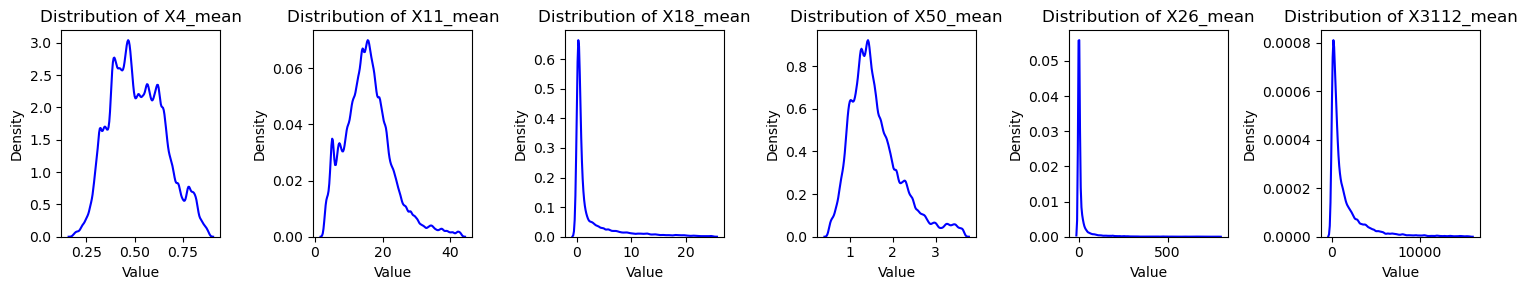

In [29]:
plot_data(train_original, mean_columns)

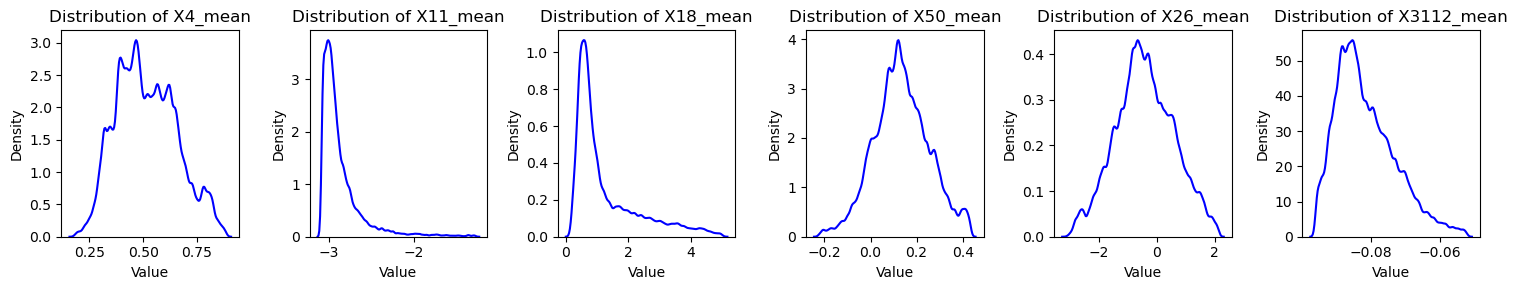

In [30]:
plot_data(train_plot, mean_columns)

In [31]:
results_training_name = './data/results_finetune_images.pickle'

if os.path.exists(results_training_name):
    results_training = pd.read_pickle(results_training_name)
else:
    columns = ['Train R2', 'Train MSE', 'Train MAE', 'Train MAPE', 'Valid R2', 'Valid MSE', 'Valid MAE', 'Valid MAPE', 'Train preds Desc', 'Valid preds Desc', 'Test preds Desc' , 'Original data Desc' 'Kaggle R2', 'Scalers', 'Log/Pot transforms']
    results_training = pd.DataFrame(columns = columns)
    results_training.index.name = 'Study name'

study_name_result = f'{study_name}_finetuned'

if study_name_result not in results_training.index:    
    results_training.loc[study_name] = [None]*len(results_training.columns)

In [33]:


train_images_path = train_df['image_path'].values
valid_images_path = valid_df['image_path'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_tabular, y_train_transformed.values))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, valid_tabular ,y_valid_transformed.values))

train_dataset = train_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)





In [34]:

## TRAINING DATA TEST
tf.keras.backend.clear_session()
gc.collect()

train_pred = finetune_model.predict(train_dataset, verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        train_pred[:, i] = scaler.inverse_transform(train_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_pred[:, i] = np.power(log_base, train_pred[:, i])
    elif log_base == 'sqrt':
        train_pred[:, i] = np.square(train_pred[:, i])
    elif log_base == 'cbrt':
        train_pred[:, i] = np.power(train_pred[:, i], 3)

R2_train = r2_score(y_train, train_pred)
MSE_train = mean_squared_error(y_train, train_pred)
MAE_train = mean_absolute_error(y_train, train_pred)
MAPE_train = mean_absolute_percentage_error(y_train, train_pred)

print(f'Train scores:\nR2 : {R2_train:.5f}, MSE : {MSE_train:.5f}, MAE : {MAE_train:.5f}, MAPE : {MAPE_train:.5f}')
results_training.at[study_name_result, 'Train R2'] = R2_train
results_training.at[study_name_result, 'Train MSE'] = MSE_train
results_training.at[study_name_result, 'Train MAE'] = MAE_train
results_training.at[study_name_result, 'Train MAPE'] = MAPE_train

trainining_preds_desc = pd.DataFrame(train_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name_result, 'Train preds Desc'] = trainining_preds_desc

2024-04-22 19:31:47.845507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,163]
	 [[{{node Placeholder/_1}}]]
2024-04-22 19:31:47.845878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_2}}]]


1230/1230 [==============================] - 675s 543ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : PowerTransformer()
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : StandardScaler()
Scaler transforming target : X3112_mean with scaler : MinMaxScaler()
Logpot transforming target : X4_mean, log transform : None
Logpot transforming target : X11_mean, log transform : 2
Logpot transforming target : X18_mean, log transform : sqrt
Logpot transforming target : X50_mean, log transform : 20
Logpot transforming target : X26_mean, log transform : 10
Logpot transforming target : X3112_mean, log transform : cbrt
Train scores:
R2 : 0.45698, MSE : 540025.59099, MAE : 151.90809, MAPE : 1.12896


In [35]:

## VALIDATION DATA TEST

tf.keras.backend.clear_session()
gc.collect()

valid_pred = finetune_model.predict(valid_dataset, verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        valid_pred[:, i] = scaler.inverse_transform(valid_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        valid_pred[:, i] = np.power(log_base, valid_pred[:, i])
    elif log_base == 'sqrt':
        valid_pred[:, i] = np.square(valid_pred[:, i])
    elif log_base == 'cbrt':
        valid_pred[:, i] = np.power(valid_pred[:, i], 3)

R2_valid = r2_score(y_valid, valid_pred)
MSE_valid = mean_squared_error(y_valid, valid_pred)
MAE_valid = mean_absolute_error(y_valid, valid_pred)
MAPE_valid = mean_absolute_percentage_error(y_valid, valid_pred)

print(f'Valid scores:\nR2 : {R2_valid:.5f}, MSE : {MSE_valid:.5f}, MAE : {MAE_valid:.5f}, MAPE : {MAPE_valid:.5f}')
results_training.at[study_name_result, 'Valid R2'] = R2_valid
results_training.at[study_name_result, 'Valid MSE'] = MSE_valid
results_training.at[study_name_result, 'Valid MAE'] = MAE_valid
results_training.at[study_name_result, 'Valid MAPE'] = MAPE_valid

valid_preds_desc = pd.DataFrame(valid_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name_result, 'Valid preds Desc'] = valid_preds_desc



2024-04-22 19:46:22.272431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,163]
	 [[{{node Placeholder/_1}}]]
2024-04-22 19:46:22.272713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_2}}]]


308/308 [==============================] - 163s 522ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : PowerTransformer()
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : StandardScaler()
Scaler transforming target : X3112_mean with scaler : MinMaxScaler()
Valid scores:
R2 : 0.32572, MSE : 616414.14664, MAE : 168.72912, MAPE : 1.91069


In [73]:
# TEST DATA 

tf.keras.backend.clear_session()
gc.collect()

test_df_copy = test_df.copy()
submission_df = test_df_copy[['id']].copy()


test_df_copy[FEATURE_COLS] = scaler_feat.transform(test_df_copy[FEATURE_COLS].values)
test_features = test_df_copy[FEATURE_COLS].values
test_images_path = test_df_copy['image_path'].values

test_images = np.array([process_path_test(path) for path in test_images_path])

print(test_images.shape)  # Expected: (num_samples, 480, 480, 3)
print(test_features.shape)  

predictions = finetune_model.predict([test_images, test_images, test_features], verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        predictions[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target: : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        predictions[:, i] = np.power(log_base, predictions[:, i])
    elif log_base == 'sqrt':
        predictions[:, i] = np.square(predictions[:, i])
    elif log_base == 'cbrt':
        predictions[:, i] = np.power(predictions[:, i], 3)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3485ebd2e0>>
Traceback (most recent call last):
  File "/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions


In [ ]:

test_preds_desc = submission_df[target_columns].describe().to_json()
results_training.at[study_name_result, 'Test preds Desc'] = test_preds_desc 

original_data_desc = train_original[mean_columns].describe().to_json()
results_training.at[study_name_result, 'Original data Desc'] = original_data_desc



In [ ]:
print(f'{str(log_transforms.items())}')
print(f'{str(scaler_transforms.items())}')

results_training.at[study_name_result, 'Scalers'] = f'{scaler_transforms}'
results_training.at[study_name_result, 'Log/Pot transforms'] = f'{str(log_transforms.items())}'



In [ ]:
results_training.at[study_name_result, 'Kaggle R2'] = None

for index, row in results_training.iterrows():
    print(f"Study Name: {index}")
    print(f'Kaggle R2: {row["Kaggle R2"]}')
    print(f"Train R2: {row['Train R2']}, Train MSE: {row['Train MSE']}, Train MAE : {row['Train MAE']}, Train MAPE: {row['Train MAPE']}")
    print(f'Valid R2: {row["Valid R2"]}, Valid MSE: {row["Valid MSE"]}, Valid MAE: {row["Valid MAE"]}, Valid MAPE: {row["Valid MAPE"]}')
    print("-" * 50)
    print("Train preds Description:")
    display(pd.read_json(row['Train preds Desc']))
    print("Valid preds Description:")
    display(pd.read_json(row['Valid preds Desc']))
    print("Test preds Description:")
    display(pd.read_json(row['Test preds Desc']))
    print("Original data Description:")
    display(pd.read_json(row['Original data Desc']))
    

In [ ]:
submission_df.head()

In [ ]:
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)

In [ ]:
with open(results_training_name, 'wb') as f:
    results_training.to_pickle(f)